# Library importing


In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import random

# import data and converting it into a pandas dataframe


In [15]:
ticker = yf.Ticker("MSFT")
stock_data = ticker.history(period="max")
stock_data = pd.DataFrame(data=stock_data)

In [16]:
window = 10
total_prediction_days = -365

stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054791,0.062849,0.054791,0.060163,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060163,0.063386,0.060163,0.062311,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062311,0.063923,0.062311,0.063386,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063386,0.063923,0.061237,0.061774,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061774,0.062311,0.060163,0.060700,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-18 00:00:00-04:00,410.630005,411.890015,403.950012,404.269989,21029900,0.0,0.0
2024-04-19 00:00:00-04:00,404.029999,405.480011,397.769989,399.119995,30276500,0.0,0.0
2024-04-22 00:00:00-04:00,400.079987,402.850006,395.750000,400.959991,20286900,0.0,0.0


# Look at the data using matplotlib

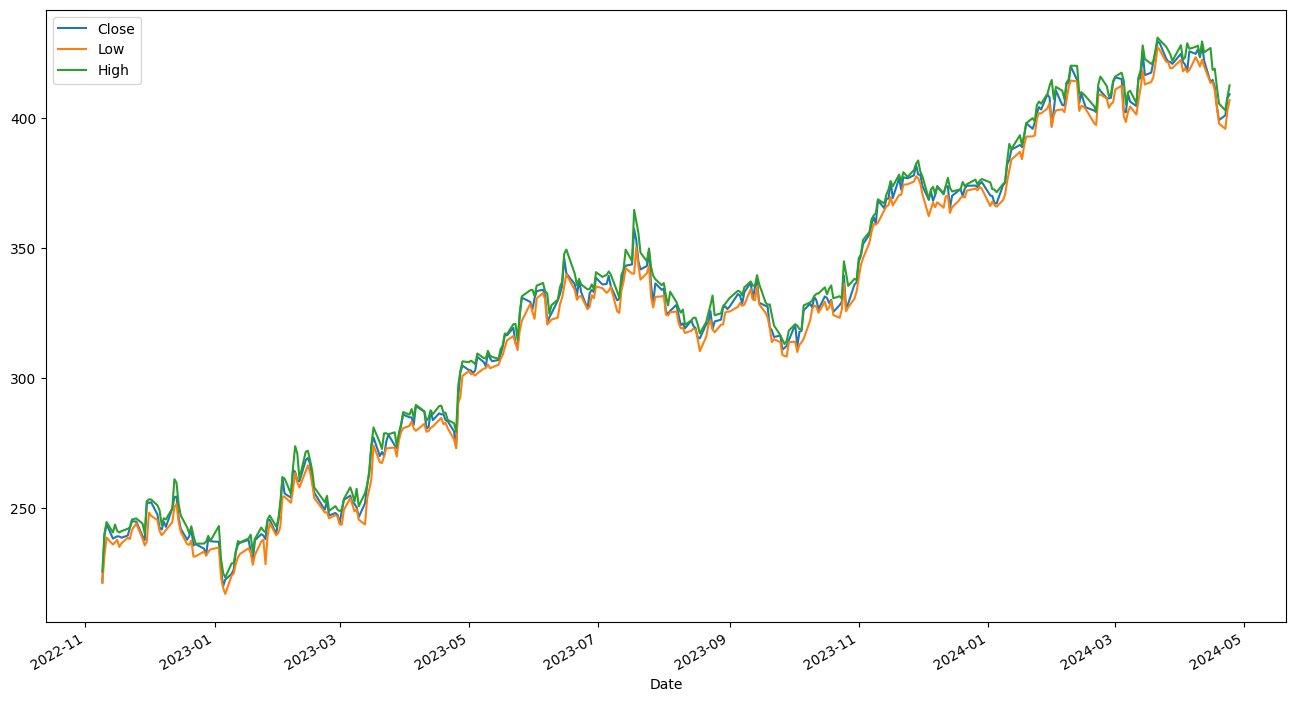

In [17]:
n = random.randint(0, len(stock_data))
stock_data['Close'][-365:].plot(kind='line', figsize=(16, 9))
stock_data['Low'][-365:].plot(kind='line', figsize=(16, 9))
stock_data['High'][-365:].plot(kind='line', figsize=(16, 9))
# stock_data['Volume'][n:n+1000].plot(kind='line', figsize=(16, 9))
# stock_data['Dividends'][n:n+1000].plot(kind='line', figsize=(16, 9))
# stock_data['Stock Splits'][n:n+1000].plot(kind='line', figsize=(16, 9))
plt.legend()

# Scale the data for calculation

In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))
scaled_data

array([[1.00091516e-05],
       [1.50137795e-05],
       [1.75174254e-05],
       ...,
       [9.33824671e-01],
       [9.49221360e-01],
       [9.52691989e-01]])

# Preparing the data to perform LSTM on the data

In [19]:
X_data = []
y_data = []

for i in range(window, len(scaled_data)):
  X_data.append(scaled_data[i-window: i, 0])
  y_data.append(scaled_data[i, 0])
X_data, y_data = np.array(X_data), np.array(y_data)
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1))

# Divide the data into train and test dataser

In [20]:
X_train, X_test = X_data[:total_prediction_days], X_data[total_prediction_days:]
y_train, y_test = y_data[:total_prediction_days], y_data[total_prediction_days:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9141, 100, 1), (365, 100, 1), (9141,), (365,))

# Creating the Long-Short Term Memory model

In [21]:
model = Sequential()

model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1) ))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units=1, activation = 'relu'))

# Compile and train fit the model on the data

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
36/36 [==============================] - 36s 844ms/step - loss: 0.0042 - val_loss: 7.1171e-04
Epoch 2/10
36/36 [==============================] - 27s 726ms/step - loss: 6.0838e-04 - val_loss: 0.0012
Epoch 3/10
36/36 [==============================] - 22s 603ms/step - loss: 4.7935e-04 - val_loss: 0.0072
Epoch 4/10
36/36 [==============================] - 24s 671ms/step - loss: 4.5433e-04 - val_loss: 0.0016
Epoch 5/10
36/36 [==============================] - 35s 992ms/step - loss: 4.4122e-04 - val_loss: 0.0025
Epoch 6/10
36/36 [==============================] - 35s 972ms/step - loss: 3.9742e-04 - val_loss: 0.0062
Epoch 7/10
36/36 [==============================] - 26s 715ms/step - loss: 3.7823e-04 - val_loss: 0.0020
Epoch 8/10
36/36 [==============================] - 23s 651ms/step - loss: 3.6060e-04 - val_loss: 0.0019
Epoch 9/10
36/36 [==============================] - 24s 657ms/step - loss: 3.5371e-04 - val_loss: 0.0034
Epoch 10/10
36/36 [==============================] - 27

# create prediction on the test dataset of the model and ploting them

12/12 [==============================] - 2s 38ms/step


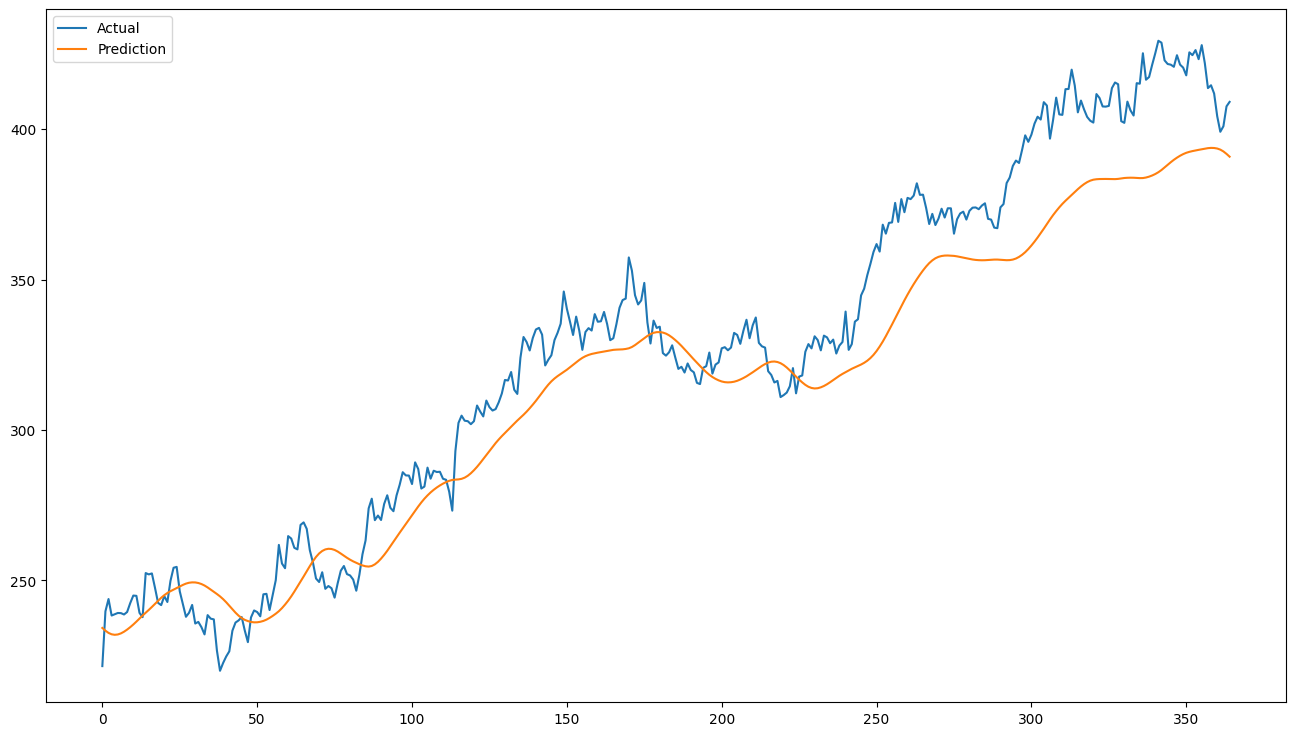

In [23]:
predictions = model.predict(X_test)
# Scaling on
predictions = scaler.inverse_transform(predictions)
y_test_inverse = np.array(stock_data['Close'][total_prediction_days:])

plt.figure(figsize=(16,9))
plt.plot(y_test_inverse, label='Actual')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()


# Calculating the accuracy over the output data to quick daily trade of stocks(buy/short)

In [24]:
buysellaccuracy = []

for i in range(1,abs(total_prediction_days)):
  if(((predictions[i][0] < predictions[i-1][0]) and (y_test_inverse[i] < y_test_inverse[i-1])) or ((predictions[i][0] > predictions[i-1][0]) and (y_test_inverse[i] > y_test_inverse[i-1]))) :
    buysellaccuracy.append(1)
  else :
    buysellaccuracy.append(-1)
buysellaccuracy.count(1)/len(buysellaccuracy)

0.47802197802197804

# Recursively predict the data and use that data as the input of the next prediction

In [25]:
X_test = X_test[0]
next_recursive = []
for _ in range(abs(total_prediction_days)):
  X_test = np.array(X_test)
  X_test = X_test.reshape((1, window, 1))
  predicted_value = model.predict(X_test)[0][0]
  next_recursive.append(predicted_value)
  X_test = np.insert(X_test, -1, predicted_value)
  X_test = X_test[1:]
next_recursive = np.array(next_recursive)
next_recursive = next_recursive.reshape(-1, 1)
next_recursive = scaler.inverse_transform(next_recursive)


1/1 [==============================] - 0s 32ms/step


# Plot all the actual data, prediction of the data and recurring prediction for long term prediction
This graph shows that LSTM is okay enough for very close predictions but the output predictions are not as accurate as to actually trade stock on this data and even this very close prediction is not very accurate to have sirious business on it.

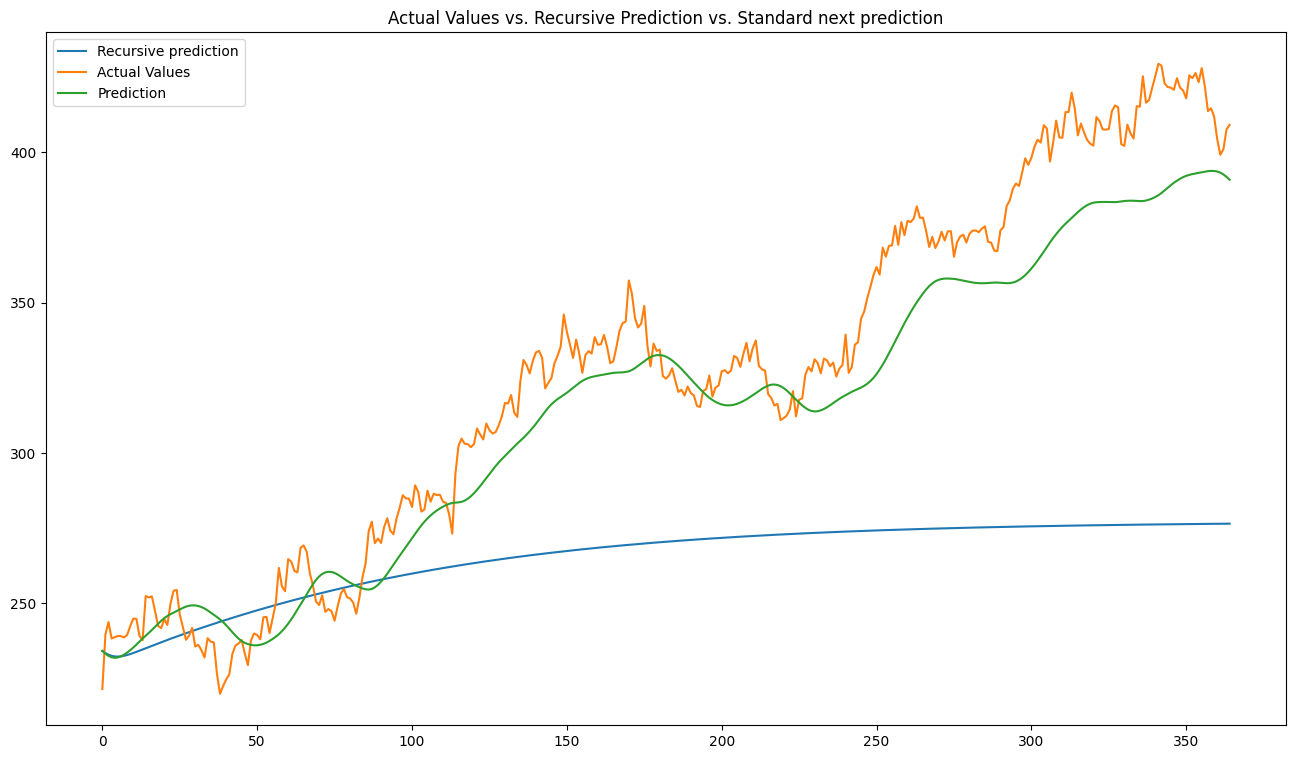

In [26]:
plt.figure(figsize=(16,9))
plt.plot(next_recursive, label=f'Recursive prediction')
plt.plot(y_test_inverse, label='Actual Values')
plt.plot(predictions, label='Prediction')

plt.legend()
plt.title('Actual Values vs. Recursive Prediction vs. Standard next prediction')

plt.show()
